In [5]:
import numpy as np
import gzip
import struct

from matplotlib import pyplot as plt

In [6]:
def get_labels():
    with gzip.open("train_labels.gz", 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
def get_features(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
def plot_image(image):
    plt.imshow(image.reshape((28,28)), cmap="gray")
    
labels = get_labels()
features = get_features("train_features.gz").reshape((60000, 784))
features = features / 255
test = get_features("test_features.gz").reshape((10000, 784))

C:\Users\marco\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """
C:\Users\marco\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [16]:
# def sigmoid(x):
#     return 1 / (1 + np.exp(0 - x))
def sigmoid(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
# def sigmoid(x):
#     return np.vectorize(lambda k: 1 / (1 + np.exp(-k)) if k >= 0 else np.exp(k) / (1 + np.exp(k)))(x)

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x,0)

def d_relu(x):
    _d_relu = lambda k: 1 if k > 0 else 0
    return np.where(x > 0, np.full(np.shape(x), 1), np.full(np.shape(x), 0))

# def leaky_relu(x, a=0.01):
#     _leaky_relu = lambda k: k if k > 0 else a*k
#     return np.vectorize(_leaky_relu)(x)

# def d_leaky_relu(x, a=0.01):
#     _d_leaky_relu = lambda k: 1 if k > 0 else a
#     return np.vectorize(_d_leaky_relu)(x)

# def tanh(x):
#     return np.tanh(x)

# def d_tanh(x):
#     return 1.0 - np.tanh(x)**2

def squared_loss(y, x):
    return (y - x) ** 2 / 2

def d_squared_loss(y, x):
    return - (y - x)

In [17]:
def run(xs, w_1, w_2, b_1, b_2):
    """
    :param x: the matrix of input data, shape (N, D)
    """
    N = xs.shape[1]
    D = xs.shape[0]
    f1 = w_1 @ xs
    f2 = (b_1 + f1.T).T
    f3 = relu(f2)
    f4 = w_2 @ f3
    f5 = (b_2 + f4.T).T
    f6 = sigmoid(f5)
    f7 = squared_loss(xs, f6)
#     f8 = np.sum(f7, axis=0)
    f9 = np.sum(f7)
    f10 = f9 / N
    
    t10 = 1
    t9 = 1 / N
    t8 = np.full((N), 1 / N)
    t7 = np.full((D, N), 1 / N)
    t6 = d_squared_loss(xs, f6) * t7
    t5 = (d_sigmoid(f5)) * t6
    t4 = t5
    tb2 = np.sum(t5, axis=1)

    t3 = w_2.T @ t4
    tw2 = (f3 @ t4.T).T

    t2 = d_relu(f2) * t3

    t1 = t2
    tb1 = np.sum(t2, axis=1)
    tw1 = t1 @ xs.T
    return f6, tw1, tw2, tb1, tb2, f10

In [23]:
def adam(weight, grad, k, m_prev, v_prev, b1=0.9, b2=0.999, l=0.0000000001, rate=0.01):
    m = b1 * m_prev + (1 - b1)*grad
    v = b2 * v_prev + (1 - b2)*(grad ** 2)
    
    m_hat = m / (1 - (b1 ** k))
    v_hat = v / (1 - (b2 ** k))
    weight -= (rate / (np.sqrt(v_hat) + l))*m_hat
    return (k+1, m, v)


In [24]:
def create_weight(shape):
    stdv = 1. / np.sqrt(shape[-1])
    return np.random.uniform(-stdv, stdv, shape)
#     rand(Uniform(-stdv, stdv), dims...)
    # rand(Normal(0,1), dims...)

w1 = create_weight((30, 784))
w2 = create_weight((784, 30))
b1 = create_weight((30,))
b2 = create_weight((784,))

In [34]:
import torch

w1_gpu = torch.from_numpy(w1)
w2_gpu = torch.from_numpy(w2)
b1_gpu = torch.from_numpy(b1)
b2_gpu = torch.from_numpy(b2)

features_gpu = torch.from_numpy(features.T)

In [35]:
past_epochs = []
past_loss_values = []

epochs = 30
previous_runnings = [torch.tensor([1,0,0]) for i in range(4)]
weights = [w1_gpu,w2_gpu,b1_gpu,b2_gpu]

for i in range(epochs):
    res, grad_w1, grad_w2, grad_b1, grad_b2, loss = run(features_gpu, w1_gpu, w2_gpu, b1_gpu, b2_gpu)
    grads = [grad_w1, grad_w2, grad_b1, grad_b2]
    for (j, (weight, previous_running, grad)) in enumerate(zip(weights, previous_runnings, grads)):
        k, m, v = previous_running
        previous_runnings[j] = adam(weight, grad, k, m, v)
    past_epochs.append(i)
    past_loss_values.append(loss)
    print(i, loss)

AttributeError: 'Tensor' object has no attribute 'T'

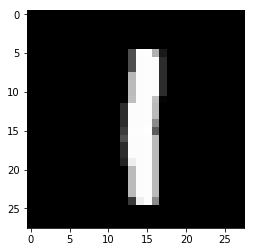

In [32]:
index = 9090

img = test[index:index+1, :]

plot_image(img)
# test = run(features.T[:,1:108], w1, w2, b1, b2)

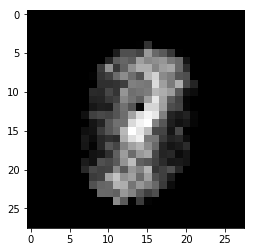

In [33]:
res_img, grad_w1, grad_w2, grad_b1, grad_b2, loss = run((img/255).T, w1, w2, b1, b2)
plot_image(res_img*255)